<a href="https://colab.research.google.com/github/pallavkumar1981/MSDS462-self-driving-car/blob/main/02_Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

* Run this notebook preferably on Google Colab so as to leverage additional RAM and GPU
* Key considerations:
    - Correct the paths below for the pickle files stored on your google drives. This is load the feature and label data for training and validation sets.
    - Keep track of the models getting stored. Store them on google drive and later download the best performing (E2E learning) model for simulation. Simulation will be run on local jupyter notebook


# 0. Mounting to google drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0. Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Normalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K

import os
import random
from scipy import pi
from datetime import datetime
import cv2
import pickle
import json
from itertools import islice

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
cv2.__version__

'4.5.4'

In [ ]:
SPLIT = 0.9

# 1. Loading prepared data (train and validation) for model development

In [ ]:
def loadPreparedDataFromPickle():
    with open('./pickle/X_train.pkl', 'rb') as f:
        Xtrain = np.array(pickle.load(f))
    with open('./pickle/y_train.pkl', 'rb') as f:
        ytrain = np.array(pickle.load(f))
    with open('./pickle/X_val.pkl', 'rb') as f:
        Xval = np.array(pickle.load(f))
    with open('./pickle/y_val.pkl', 'rb') as f:
        yval = np.array(pickle.load(f))
    return Xtrain, ytrain, Xval, yval

In [ ]:
%%time
X_train, y_train, X_val, y_val = loadPreparedDataFromPickle()

Wall time: 31.6 s


# 2. Model development

## 2.1 End-to-end learning (Nvidia architecture)

In [ ]:
checkpoint_file_name = './models/self_drive_model_E2E_v1.hdf5'

In [ ]:
def custom_activation(x):
    return tf.multiply(tf.math.atan(x), 2) #  arctan range is [-pi/2, pi/2]. so we have to get the angle between [-pi, pi] so we are multiplying by 2

In [ ]:
#to refer the model architecture: https://developer.nvidia.com/blog/deep-learning-self-driving-cars/
#to use atan as a activation function refer: https://www.tensorflow.org/api_docs/python/tf/math/atan

img_input = tf.keras.Input(img_size)
x = tf.keras.layers.Conv2D(filters=24, kernel_size=(5,5), strides=(2,2), padding='valid', name='conv-1')(img_input)
x = tf.keras.layers.Conv2D(filters=36, kernel_size=(5,5), strides=(2,2), padding='valid', name='conv-2')(x)
x = tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), strides=(2,2), padding='valid', name='conv-3')(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', name='conv-4')(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', name='conv-5')(x)
x = tf.keras.layers.Flatten(name='flatten')(x)
x = tf.keras.layers.Dense(1164, activation='relu', name='dense_layer-1')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout-1')(x)
x = tf.keras.layers.Dense(100, activation='relu', name='dense_layer-2')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout-2')(x)
x = tf.keras.layers.Dense(50, activation='relu', name='dense_layer-3')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout-3')(x)
x = tf.keras.layers.Dense(10, activation='relu', name='dense_layer-4')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout-4')(x)
output = tf.keras.layers.Dense(1, activation=custom_activation, name='output')(x) #note we have used atan to use tan inverse activation

model_e2e = tf.keras.models.Model(inputs=img_input, outputs=output, name='model-1')

In [ ]:
model_e2e.summary()

Model: "model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 66, 200, 3)]      0         
                                                                 
 conv-1 (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv-2 (Conv2D)             (None, 14, 47, 36)        21636     
                                                                 
 conv-3 (Conv2D)             (None, 5, 22, 48)         43248     
                                                                 
 conv-4 (Conv2D)             (None, 3, 20, 64)         27712     
                                                                 
 conv-5 (Conv2D)             (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0   

In [ ]:
model_e2e.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

In [ ]:
BATCH_SIZE = 100
NBR_EPOCHS = 30

In [ ]:
model_checkpoint = ModelCheckpoint(checkpoint_file_name, monitor='val_loss', verbose=1, save_best_only=True)
callbacks_list = [model_checkpoint]

In [ ]:
%%time
history = model_e2e.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NBR_EPOCHS, 
                      validation_data=(X_val, y_val), callbacks=callbacks_list, verbose=2)
model_e2e.save(checkpoint_file_name)

Epoch 1/30

Epoch 1: val_loss improved from inf to 0.20810, saving model to ./drive/MyDrive/Colab_Notebooks/MSDS462-Computer_Vision-Final_Project/models/self_drive_model_E2E_v1.hdf5
409/409 - 29s - loss: 0.2754 - val_loss: 0.2081 - 29s/epoch - 70ms/step
Epoch 2/30

Epoch 2: val_loss improved from 0.20810 to 0.13767, saving model to ./drive/MyDrive/Colab_Notebooks/MSDS462-Computer_Vision-Final_Project/models/self_drive_model_E2E_v1.hdf5
409/409 - 9s - loss: 0.2007 - val_loss: 0.1377 - 9s/epoch - 21ms/step
Epoch 3/30

Epoch 3: val_loss improved from 0.13767 to 0.10264, saving model to ./drive/MyDrive/Colab_Notebooks/MSDS462-Computer_Vision-Final_Project/models/self_drive_model_E2E_v1.hdf5
409/409 - 9s - loss: 0.1478 - val_loss: 0.1026 - 9s/epoch - 21ms/step
Epoch 4/30

Epoch 4: val_loss improved from 0.10264 to 0.06697, saving model to ./drive/MyDrive/Colab_Notebooks/MSDS462-Computer_Vision-Final_Project/models/self_drive_model_E2E_v1.hdf5
409/409 - 8s - loss: 0.1094 - val_loss: 0.0670 -

### 2.1.1 Model loss plot


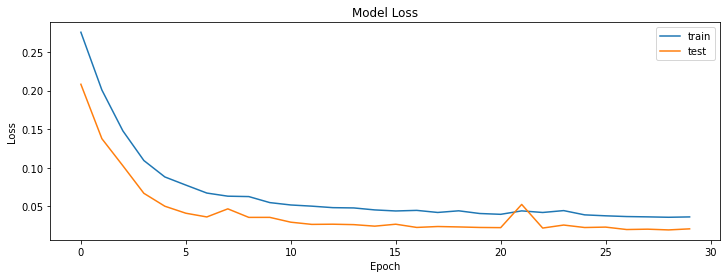

In [ ]:
# history plot for accuracy
plt.figure(figsize=(12,4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

### 2.1.2 Prediction

In [ ]:
%%time
#https://stackoverflow.com/questions/55779286/valueerror-unknown-activation-function-my-custom-activation-function
model_e2e = tf.keras.models.load_model(checkpoint_file_name, 
                                          custom_objects={'custom_activation':custom_activation})

Wall time: 4.96 s


In [ ]:
%%time
y_val_pred = []

for i in X_val:
    #i = cv2.resize(i, (200,66))
    #i = i/255.0
    i = np.expand_dims(i, axis=0)
    prediction = model_e2e.predict(i)
    y_val_pred.extend(prediction[0])

CPU times: user 4min 5s, sys: 18.7 s, total: 4min 24s
Wall time: 4min 13s


In [ ]:
 # Calculation of Mean Squared Error (MSE)
print('Test_MSE: %f' % mean_squared_error(y_val,y_val_pred))

Test_MSE: 0.020945


## 2.2 (Modified) End-to-end learning (Nvidia architecture) - with MaxPooling

In [ ]:
filepath = './drive/MyDrive/Colab_Notebooks/MSDS462-Computer_Vision-Final_Project/models/self_drive_model_E2E_v2.hdf5'

In [ ]:
def keras_model():
    img_input = tf.keras.Input(img_size)
    
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',  name='conv-1')(img_input)
    x = tf.keras.layers.MaxPool2D((2, 2), padding='valid')(x)
    
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',  name='conv-2')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), padding='valid')(x)
    
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu',  name='conv-3')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), padding='valid')(x)
    
    x = tf.keras.layers.Flatten(name='flatten')(x)
    x = tf.keras.layers.Dropout(0.5, name='dropout-1')(x)
    
    x = tf.keras.layers.Dense(128, activation='relu', name='dense_layer-1')(x)
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_layer-2')(x)
    
    output = tf.keras.layers.Dense(1, activation='relu', name='output')(x)
    model = tf.keras.models.Model(inputs=img_input, outputs=output, name='model-1')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')
    
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
    callbacks_list = [model_checkpoint]
    
    return model, callbacks_list

In [ ]:
model_e2e_2, callbacks_list = keras_model()

In [ ]:
%%time
history = model_e2e_2.fit(X_train, y_train, validation_data=(X_val, y_val), 
                epochs=10, batch_size=16,callbacks=callbacks_list)
model_e2e_2.save(filepath)

Epoch 1/10
2552/2555 [============================>.] - ETA: 0s - loss: 0.2940
Epoch 1: val_loss did not improve from 0.27633
2555/2555 [==============================] - 22s 9ms/step - loss: 0.2938 - val_loss: 0.2763
Epoch 2/10
2554/2555 [============================>.] - ETA: 0s - loss: 0.2938
Epoch 2: val_loss did not improve from 0.27633
2555/2555 [==============================] - 23s 9ms/step - loss: 0.2938 - val_loss: 0.2763
Epoch 3/10
2555/2555 [==============================] - ETA: 0s - loss: 0.2938
Epoch 3: val_loss did not improve from 0.27633
2555/2555 [==============================] - 22s 9ms/step - loss: 0.2938 - val_loss: 0.2763
Epoch 4/10
2554/2555 [============================>.] - ETA: 0s - loss: 0.2938
Epoch 4: val_loss did not improve from 0.27633
2555/2555 [==============================] - 23s 9ms/step - loss: 0.2938 - val_loss: 0.2763
Epoch 5/10
2549/2555 [============================>.] - ETA: 0s - loss: 0.2943
Epoch 5: val_loss did not improve from 0.27633
25

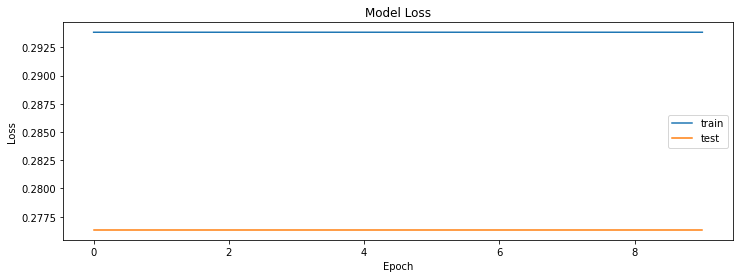

In [ ]:
# history plot for accuracy
plt.figure(figsize=(12,4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

### 2.2.1 Prediction

In [ ]:
%%time
model_e2e_2 = tf.keras.models.load_model(filepath)

In [ ]:
%%time
y_val_pred = []

for i in X_val:
    i = np.expand_dims(i, axis=0)
    prediction = model_e2e_2.predict(i)
    y_val_pred.extend(prediction[0])

CPU times: user 4min 14s, sys: 15.7 s, total: 4min 30s
Wall time: 4min 21s


In [ ]:
# Calculation of Mean Squared Error (MSE)
print('Test_MSE: %f' % mean_squared_error(y_val,y_val_pred))

Test_MSE: 0.276331


## 2.3 VGG16

In [ ]:
filepath = "./drive/MyDrive/Colab_Notebooks/MSDS462-Computer_Vision-Final_Project/models/self_drive_vgg16.h5"

In [ ]:
model_vgg16 = tf.keras.applications.VGG16(input_shape=img_size,
                                            include_top = False, 
                                            weights='imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 66, 200, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 66, 200, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 66, 200, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 33, 100, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 33, 100, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 33, 100, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 50, 128)       0     

In [ ]:
model_vgg16.trainable = False

Adding custom dense layer on top of the VGG16 convolutional layers 

In [ ]:
inputs = tf.keras.Input(shape=img_size)
x = tf.keras.applications.vgg16.preprocess_input(inputs)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = model_vgg16(x, training=False)
#x = tf.keras.layers.GlobalAveragePooling2D()(x)    # Recommended if the number of images is less (< 10k or so)

#Dense Layer
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1164)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(100)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(50)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10)(x)

# Output layer with tanh activation 
outputs = tf.keras.layers.Dense(1,activation='tanh')(x)

In [ ]:
# With all the components in place, we build our final model architecture.
model_vgg16 = tf.keras.Model(inputs, outputs)

In [ ]:
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 66, 200, 3)]      0         
                                                                 
 tf.__operators__.getitem (S  (None, 66, 200, 3)       0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 66, 200, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 2, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 1164)              7152780   
                                                             

In [ ]:
adam = Adam(learning_rate=1e-7, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_vgg16.compile(optimizer="adam", loss="mse", metrics='mean_squared_error')

In [ ]:
BATCH_SIZE = 100
NBR_EPOCHS = 10

In [ ]:
checkpoint1 = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
callbacks_list = [checkpoint1]

In [ ]:
%%time
history = model_vgg16.fit(X_train, y_train, validation_data=(X_val, y_val), 
          epochs=NBR_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list)
model_vgg16.save(filepath)

Epoch 1/10
409/409 [==============================] - ETA: 0s - loss: 1.2501 - mean_squared_error: 1.2501
Epoch 1: val_loss improved from inf to 1.21666, saving model to ./drive/MyDrive/Colab_Notebooks/MSDS462-Computer_Vision-Final_Project/models/self_drive_vgg16.h5
409/409 [==============================] - 41s 94ms/step - loss: 1.2501 - mean_squared_error: 1.2501 - val_loss: 1.2167 - val_mean_squared_error: 1.2167
Epoch 2/10
409/409 [==============================] - ETA: 0s - loss: 1.2330 - mean_squared_error: 1.2330
Epoch 2: val_loss did not improve from 1.21666
409/409 [==============================] - 34s 83ms/step - loss: 1.2330 - mean_squared_error: 1.2330 - val_loss: 1.2167 - val_mean_squared_error: 1.2167
Epoch 3/10
409/409 [==============================] - ETA: 0s - loss: 1.2328 - mean_squared_error: 1.2328
Epoch 3: val_loss did not improve from 1.21666
409/409 [==============================] - 34s 83ms/step - loss: 1.2328 - mean_squared_error: 1.2328 - val_loss: 1.2167 -

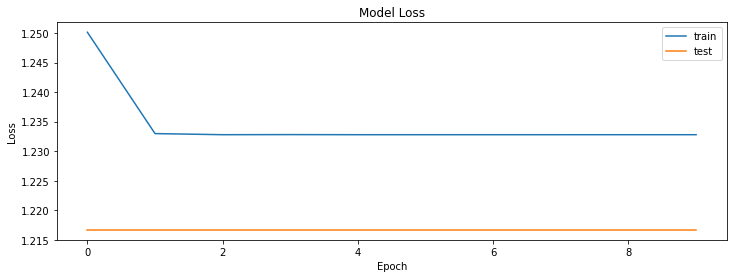

In [ ]:
# history plot for accuracy
plt.figure(figsize=(12,4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

### 2.3.1 Prediction

In [ ]:
%%time
model_vgg16 = tf.keras.models.load_model(filepath)

CPU times: user 649 ms, sys: 224 ms, total: 873 ms
Wall time: 3.3 s


In [ ]:
%%time
y_val_pred = []

for i in X_val:
    i = np.expand_dims(i, axis=0)
    prediction = model_vgg16.predict(i)
    y_val_pred.extend(prediction[0])

CPU times: user 4min 20s, sys: 13.8 s, total: 4min 34s
Wall time: 4min 20s


In [ ]:
# Calculation of Mean Squared Error (MSE)
print('Test_MSE: %f' % mean_squared_error(y_val,y_val_pred))

Test_MSE: 1.216659


## 2.4 MobileNetV2

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import Dense, Activation, Flatten, Conv2D, Lambda, Input
from keras.models import Model
from keras.callbacks import History

In [ ]:
Mobile_model = MobileNet(include_top=False, weights= None, input_shape=img_size)

#keeping the weights intact
for layer in Mobile_model.layers:
    layer.trainable = True

inputs = Input(img_size) 

lambdas = Lambda(lambda x: x / 127.5 - 1.)(inputs)

outputs = Mobile_model(lambdas)

model = Model(inputs, outputs)

last  = model.output

x = Flatten()(last)
x = Dropout(0.5)(x)
x = Dense(288)(x)
x = Dense(9)(x)
preds = Dense(1)(x)

model_mobileNet = Model(model.input, preds)
    
model_mobileNet.compile(optimizer=Adam(learning_rate=0.0001), loss="mse")
model_mobileNet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 66, 200, 3)]      0         
                                                                 
 lambda (Lambda)             (None, 66, 200, 3)        0         
                                                                 
 mobilenet_1.00_66 (Function  (None, 2, 6, 1024)       3228864   
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dropout_3 (Dropout)         (None, 12288)             0         
                                                                 
 dense_5 (Dense)             (None, 288)               3539232   
                                                           

In [ ]:
filepath = "./drive/MyDrive/Colab_Notebooks/MSDS462-Computer_Vision-Final_Project/models/self_drive_mobileNetV2.h5"

es = EarlyStopping(monitor='val_loss', verbose=1)
checkpoint = ModelCheckpoint(filepath, verbose=1,monitor='val_loss', save_best_only=True)
hist = History()
callbacks_list = [es,checkpoint,hist]

In [ ]:
%%time
history = model_mobileNet.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32,callbacks=callbacks_list)
model_mobileNet.save(filepath)

Epoch 1/10
1278/1278 [==============================] - ETA: 0s - loss: 1.5743
Epoch 1: val_loss improved from inf to 0.47985, saving model to ./drive/MyDrive/Colab_Notebooks/MSDS462-Computer_Vision-Final_Project/models/self_drive_mobileNetV2.h5
1278/1278 [==============================] - 69s 51ms/step - loss: 1.5743 - val_loss: 0.4798
Epoch 2/10
1277/1278 [============================>.] - ETA: 0s - loss: 0.5001
Epoch 2: val_loss improved from 0.47985 to 0.41520, saving model to ./drive/MyDrive/Colab_Notebooks/MSDS462-Computer_Vision-Final_Project/models/self_drive_mobileNetV2.h5
1278/1278 [==============================] - 64s 50ms/step - loss: 0.5001 - val_loss: 0.4152
Epoch 2: early stopping
CPU times: user 2min 22s, sys: 6.06 s, total: 2min 28s
Wall time: 2min 16s


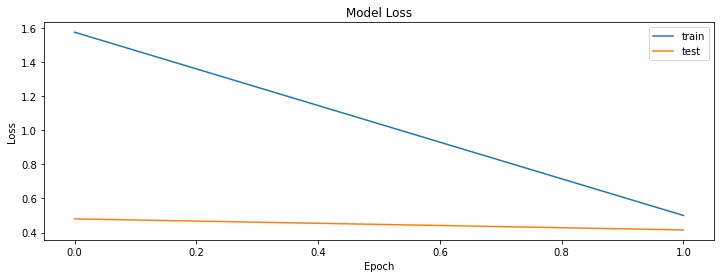

In [ ]:
# history plot for accuracy
plt.figure(figsize=(12,4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

### 2.4.1 Prediction

In [ ]:
%%time
model_mobileNet = tf.keras.models.load_model(filepath)

In [ ]:
%%time
y_val_pred = []

for i in X_val:
    i = np.expand_dims(i, axis=0)
    prediction = model_mobileNet.predict(i)
    y_val_pred.extend(prediction[0])

CPU times: user 4min 32s, sys: 13.5 s, total: 4min 45s
Wall time: 4min 29s


In [ ]:
# Calculation of Mean Squared Error (MSE)
print('Test_MSE: %f' % mean_squared_error(y_val,y_val_pred))

Test_MSE: 0.415196


## 2.5 Auto-encoder

In [ ]:
from keras.layers import MaxPooling2D, Dropout,UpSampling2D, BatchNormalization

In [ ]:
def keras_model(image_x, image_y):
    
    model = Sequential()
    model.add(Lambda(lambda x: x / 127.5 - 1., input_shape=img_size))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='valid'))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='valid'))
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='valid'))
    
    #decoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(UpSampling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(UpSampling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(UpSampling2D((2, 2)))
    
    model.add(Conv2D(1, (3, 3), activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss="mse")
    
    model.summary()
    return model

In [ ]:
%%time
model_AE = keras_model(66,200)
filepath = "./drive/MyDrive/Colab_Notebooks/MSDS462-Computer_Vision-Final_Project/models/self_drive_AE.h5"

es = EarlyStopping(monitor='val_loss', verbose=1)
checkpoint = ModelCheckpoint(filepath, verbose=1,monitor='val_loss', save_best_only=True)
callbacks_list = [es,checkpoint,hist]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 66, 200, 3)        0         
                                                                 
 conv2d (Conv2D)             (None, 66, 200, 128)      3584      
                                                                 
 batch_normalization (BatchN  (None, 66, 200, 128)     512       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 33, 100, 128)     0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 100, 64)       73792     
                                                                 
 batch_normalization_1 (Batc  (None, 33, 100, 64)      2

In [ ]:
%%time
history = model_AE.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32,callbacks=callbacks_list)
model_AE.save(filepath)

Epoch 1/20
1278/1278 [==============================] - ETA: 0s - loss: 0.4248
Epoch 1: val_loss improved from inf to 0.26597, saving model to ./drive/MyDrive/Colab_Notebooks/MSDS462-Computer_Vision-Final_Project/models/self_drive_AE.h5
1278/1278 [==============================] - 64s 49ms/step - loss: 0.4248 - val_loss: 0.2660
Epoch 2/20
1277/1278 [============================>.] - ETA: 0s - loss: 0.2396
Epoch 2: val_loss did not improve from 0.26597
1278/1278 [==============================] - 60s 47ms/step - loss: 0.2396 - val_loss: 0.2986
Epoch 2: early stopping
CPU times: user 1min 43s, sys: 7.15 s, total: 1min 50s
Wall time: 2min 7s


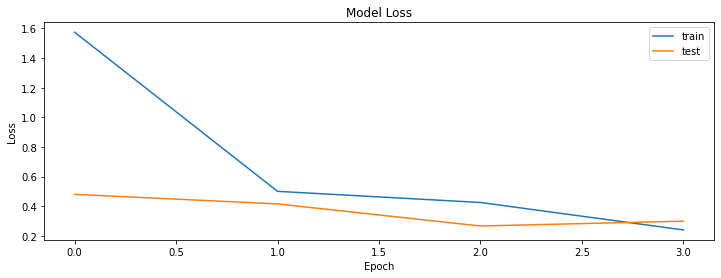

In [ ]:
# history plot for accuracy
plt.figure(figsize=(12,4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

### 2.5.1 Prediction

In [ ]:
%%time
model_AE = tf.keras.models.load_model(filepath)

CPU times: user 435 ms, sys: 80.4 ms, total: 516 ms
Wall time: 506 ms


In [ ]:
%%time
y_val_pred = []

for i in X_val:
    i = np.expand_dims(i, axis=0)
    prediction = model_AE.predict(i)
    y_val_pred.extend(prediction[0])

CPU times: user 4min 16s, sys: 14.4 s, total: 4min 30s
Wall time: 4min 17s


In [ ]:
# Calculation of Mean Squared Error (MSE)
print('Test_MSE: %f' % mean_squared_error(y_val,y_val_pred))

Test_MSE: 0.298610


# 3. Model comparison

In [ ]:
from prettytable import PrettyTable

In [ ]:
x = PrettyTable()
x.field_names = ["#", "Model", "Validation Loss", "MSE"]
x.add_row([1, "Base model - zero", "Not Avail", 0.276331])
x.add_row([2, "Base model - mean", "Not Avail", 0.275442])
x.add_row([3, "End-to-end learning (Nvidia architecture)", 0.01957, 0.020945])
x.add_row([4, "(Modified) End-to-end learning (Nvidia architecture) - with MaxPooling", 0.27633, 0.276331])
x.add_row([5, "VGG16", 1.21666, 1.216659])
x.add_row([6, "MobileNetV2", 0.4152, 0.415196])
x.add_row([7, "Auto-encoder", 0.26597, 0.298610])
print(x)

+---+------------------------------------------------------------------------+-----------------+----------+
| # |                                 Model                                  | Validation Loss |   MSE    |
+---+------------------------------------------------------------------------+-----------------+----------+
| 1 |                           Base model - zero                            |    Not Avail    | 0.276331 |
| 2 |                           Base model - mean                            |    Not Avail    | 0.275442 |
| 3 |               End-to-end learning (Nvidia architecture)                |     0.01957     | 0.020945 |
| 4 | (Modified) End-to-end learning (Nvidia architecture) - with MaxPooling |     0.27633     | 0.276331 |
| 5 |                                 VGG16                                  |     1.21666     | 1.216659 |
| 6 |                              MobileNetV2                               |      0.4152     | 0.415196 |
| 7 |                       